In [10]:
%load_ext autoreload
%autoreload 2
import math

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import os

from skimage import io, color
from skimage.data import astronaut
from skimage.color import rgb2gray, gray2rgb
from skimage.segmentation import mark_boundaries, find_boundaries
import cv2
from seeds import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import math
import itertools
import operator
from skimage.feature import graycoprops
from skimage.feature import graycomatrix
# ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import aaa
import pickle
import math
from skimage import io, color
import numpy as np
from tqdm import trange
from extraction import *
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import binary_dilation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#DATA_PATH = "/Users/sunyiyou/cudi_research"
DATA_PATH = "/Volumes/NIH-AA/florian/graph_intermediate"
patient_id = "TULIP/AVL-061"

#bmode = aaa.load(os.path.join(DATA_PATH,patient_id,"bmode_texture_cropped_0.aaa"))
#ceus_4d = aaa.load(os.path.join(DATA_PATH,patient_id,"ceus_lowres_0_75_0.aaa"))
ceus_4d = aaa.load(os.path.join(DATA_PATH,patient_id,"ceus_texture_frames_cropped_0.aaa"))

print(ceus_4d.keys())
print(ceus_4d['data4d'].shape)

dict_keys(['voxel_size_mm', 'origin_mm', 'timestamps_s', 'dynamic_range_db', 'max_radius_mm', 'data4d', 'is_valid', 'type', 'scan_settings'])
(287, 224, 234, 20)


In [7]:
#img = astronaut()
img = ceus_4d['data4d'][50:100,:,:,13]
#img = rgb2gray(img)
print(img.shape)

(50, 224, 234)


In [6]:
a = np.array([[[1,1,1,2,2,2,3,3,3],[5,5,5,6,6,6,7,7,7]],[[1,1,1,2,2,2,3,3,3],[5,5,5,6,6,6,7,7,7]]])
a = np.ones((10,10,10))

print(np.argwhere(a[3:6,3:6,3:6]))
print(np.argwhere(a[3:6,3:6,3:6]) + np.array([1,1,1]))

[[0 0 0]
 [0 0 1]
 [0 0 2]
 [0 1 0]
 [0 1 1]
 [0 1 2]
 [0 2 0]
 [0 2 1]
 [0 2 2]
 [1 0 0]
 [1 0 1]
 [1 0 2]
 [1 1 0]
 [1 1 1]
 [1 1 2]
 [1 2 0]
 [1 2 1]
 [1 2 2]
 [2 0 0]
 [2 0 1]
 [2 0 2]
 [2 1 0]
 [2 1 1]
 [2 1 2]
 [2 2 0]
 [2 2 1]
 [2 2 2]]
[[1 1 1]
 [1 1 2]
 [1 1 3]
 [1 2 1]
 [1 2 2]
 [1 2 3]
 [1 3 1]
 [1 3 2]
 [1 3 3]
 [2 1 1]
 [2 1 2]
 [2 1 3]
 [2 2 1]
 [2 2 2]
 [2 2 3]
 [2 3 1]
 [2 3 2]
 [2 3 3]
 [3 1 1]
 [3 1 2]
 [3 1 3]
 [3 2 1]
 [3 2 2]
 [3 2 3]
 [3 3 1]
 [3 3 2]
 [3 3 3]]


In [40]:
p = SEEDSProcessor(img, 1000, 3, 8)

p.init_clusters()

p.iterate_times(3000)

Lossy conversion from float64 to uint8. Range [441.0, 550.0]. Convert image to uint8 prior to saving to suppress this warning.


init cluster number 660
init seg max 660.0
SEEDS initilization completed


 37%|███▋      | 1114/3000 [1:23:16<2:38:27,  5.04s/it]/Users/sunyiyou/cudi_research/notebooks/slic/seeds.py:129: RuntimeWarning: invalid value encountered in divide
  hist = np.array(hist)/NM
100%|██████████| 3000/3000 [4:04:52<00:00,  4.90s/it]


### results

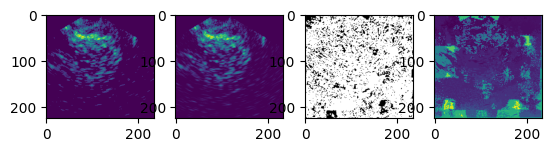

In [44]:
plt.subplot(1,4,1)
plt.imshow(p.hist[25,:,:])
plt.subplot(1,4,2)
plt.imshow(img[25,:,:])
plt.subplot(1,4,3)
plt.imshow(find_boundaries(p.Segment[25,:,:]),cmap='gray')
plt.subplot(1,4,4)
plt.imshow(p.Segment[25,:,:])

### No need to check

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


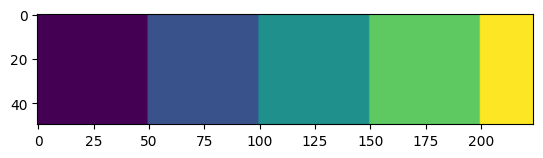

In [169]:
plt.imshow(p.Segment[:,:,0])
print(np.where(p.Segment[:,:,0]==0))
a = np.where(p.Segment[:,:,2]==0)
print(a)
plt.scatter(a[0],a[1],marker='x',color='r')

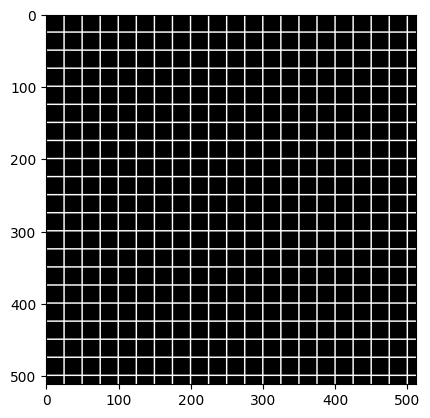

In [59]:
plt.imshow(p.boundary[:,:,0],cmap='gray')

In [222]:
print(p.hist[p.Segment==372])


a = np.unique(p.hist[p.Segment==372],return_counts=True)
print(a)
print(b)

[0. 0. 0. ... 0. 0. 0.]
(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]), array([134, 114,  39,  36,  34,  22,  24,  35, 812]))
(array([1]), array([5]))


In [184]:
cluster = p.clusters[102]
num = cluster.num_pixels

print(cluster.num_pixels)
print(np.array(cluster.color_hist).shape)
print(np.sum(np.array(cluster.color_hist)/num))
print(len(cluster.color_bins))


1250
(11,)
1.0
12


In [202]:

from collections import Counter
a = np.array([5,5,2,2,2,3,3,3,3])

#counts = np.bincount(a)
counts = np.unique(a,return_counts=True)
b = np.arange(np.min(a),np.max(a))
print(b)
print(counts[0])

[2 3 4]
[2 3 5]


In [171]:
a = p.Segment[:,:,:].flatten()
bins = np.max(a)-np.min(a)
print(bins)
print(p.Segment[10,:,0])
boundary_hist, expo_clusters= np.histogram(p.Segment.flatten(),int(bins))

print(np.max(a),np.min(a))
print(boundary_hist,expo_clusters)

441
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 1

(512, 512, 3)
(512, 512, 3)
(260496, 2)
[138286  64154 192714 157963 206546 118543 141865 236589 134999 209105]
[[270 316]
 [125 279]
 [378 181]
 [309 314]
 [405 216]
 [231 502]
 [277 318]
 [464 110]
 [264  95]
 [410 220]]
270 316
125 279
378 181
309 314
405 216
231 502
277 318
464 110
264 95
410 220


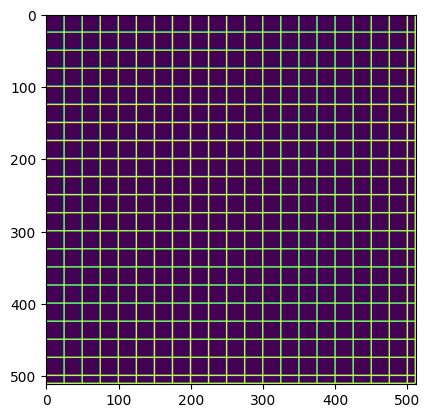

In [206]:
print(p.Segment.shape)
print(p.boundary.shape)
boundary = find_boundaries(p.Segment)
plt.imshow(boundary[:,:,0])
boundary_pixels = np.argwhere(boundary[:,:,2])
print(boundary_pixels.shape)
iteration_pixels = np.random.choice(range(boundary_pixels.shape[0]),10)
print(iteration_pixels)
print(boundary_pixels[iteration_pixels])

for h,w in boundary_pixels[iteration_pixels]:
    print(h,w)

In [31]:
N = 9
N_step = int(N/2)

a= np.histogram(p.Segment[10-N_step:10+N_step+1,10-N_step:10+N_step+1,10-N_step:10+N_step+1].flatten())
print(a[0]/(N*N*N))
b = a[0]/(N*N*N)
print(np.sum(b*b))
print(p.Segment[1-N_step:1+N_step+1,1-N_step:1+N_step+1,1-N_step:1+N_step+1].shape)

[0.66666667 0.         0.         0.         0.         0.
 0.         0.         0.         0.33333333]
0.5555555555555556
(0, 0, 0)


In [59]:
print(p.Segment[5,:,2])

[151. 151. 151. 151. 151. 151. 151. 151. 151. 151. 151. 151. 151. 151.
 151. 151. 151. 165. 165. 165. 165. 165. 165. 165. 165. 165. 165. 165.
 165. 165. 165. 165. 165. 165. 179. 179. 179. 179. 179. 179. 179. 179.
 179. 179. 179. 179. 179. 179. 179. 179. 179. 193. 193. 193. 193. 193.
 193. 193. 193. 193. 193. 193. 193. 193. 193. 193. 193. 193. 207. 207.
 207. 207. 207. 207. 207. 207. 207. 207. 207. 207. 207. 207. 207. 207.
 207. 221. 221. 221. 221. 221. 221. 221. 221. 221. 221. 221. 221. 221.
 221. 221. 221. 221. 235. 235. 235. 235. 235. 235. 235. 235. 235. 235.
 235. 235. 235. 235. 235. 235. 235. 249. 249. 249. 249. 249. 249. 249.
 249. 249. 249. 249. 249. 249. 249. 249. 249. 249. 263. 263. 263. 263.
 263. 263. 263. 263. 263. 263. 263. 263. 263. 263. 263. 263. 263. 277.
 277. 277. 277. 277. 277. 277. 277. 277. 277. 277. 277. 277. 277. 277.
 277. 277. 291. 291. 291. 291. 291. 291. 291. 291. 291. 291. 291. 291.
 291. 291. 291. 291. 291. 305. 305. 305. 305. 305. 305. 305. 305. 305.
 305. 

467631
(10, 224, 234)
AxesImage(80,52.8;496x369.6)


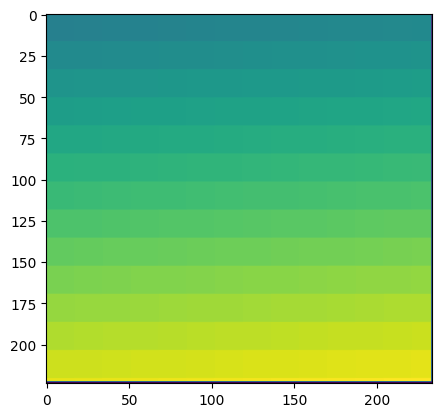

In [60]:
print(np.count_nonzero(p.Segment))
print(p.Segment.shape)

print(plt.imshow(p.Segment[5,:,:]))